I believe that I understand linear regression - how it behaves, how to evaluate if a fit is good or not, how to evaluate uncertainties in the underlying model, etc. On the other hand, I have a pretty poor understanding of what neural networks are doing, and how to extract uncertainties from the underlying model. Hence, in this document, I will compare the use of a neural network using theano with linear regression to attempt to get a feel for it. 

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import numpy as np

import theano
import theano.tensor as T
rng = np.random.RandomState(42)

import sys
import time

theano.config.floatX = 'float32'

I will construct a neural network with a scalar input $x$, and a scalar input $y$, with a hidden layer of arbitrary size (25 in this case). This neural network can be described as: ```y = W1 * sigmoid(W0 * x + b0) + b1```. Here are the initialized variables.

In [134]:
# Step 1. Declare Theano variables
x = T.fmatrix()
y = T.fmatrix()
# size of our image patches, and number of output units (classes)
hidden_size = 25
W0 = theano.shared(value=np.zeros((1, hidden_size),                            
                dtype=theano.config.floatX),
                name='W0',
                borrow=True
        )
b0 = theano.shared(value=np.zeros((hidden_size,), # number of output units (classes)
                dtype=theano.config.floatX),
                name='b0',
                borrow=True
        )
W1 = theano.shared(value=np.zeros((hidden_size, 1),                            
                dtype=theano.config.floatX),
                name='W1',
                borrow=True
        )
b1 = theano.shared(value=np.zeros((1,), # number of output units (classes)
                dtype=theano.config.floatX),
                name='b1',
                borrow=True
        )

And here is the definition of the fit function `y_pred` as described previously. It will minimize the cost function, which is simple least squares.

In [135]:
# Step 2. Construct Theano expression graph

y_pred = (T.dot(T.nnet.softmax(T.dot(x, W0) + b0), W1) + b1)
cost   = T.mean((y - y_pred)**2)

Here are the gradients of the cost function with respect to each free parameter in the model, and the update steps based on the gradient.

In [136]:
g_W0 = T.grad(cost=cost, wrt=W0)
g_b0 = T.grad(cost=cost, wrt=b0)
g_W1 = T.grad(cost=cost, wrt=W1)
g_b1 = T.grad(cost=cost, wrt=b1)

learning_rate = 0.1

updates = [(W0, W0 - learning_rate * g_W0),
           (b0, b0 - learning_rate * g_b0),
           (W1, W1 - learning_rate * g_W1),
           (b1, b1 - learning_rate * g_b1),]

This is the compiled training and validation function for the model

In [137]:
# Step 3. Compile expressions to functions
train = theano.function(inputs=[x, y],
                 outputs=cost,
                 updates=updates)

validate = theano.function(inputs=[x, y],
                           outputs=cost)

Here is where I am defining my artificial data to use on the neural network. The artificial data is just a 1D polynomial.

In [278]:
N = 100
valid = N//10
xe = np.linspace(-2.0, 2.0, N)
ye = 2 * (1 + xe**2/4.0) * np.random.normal(size=(N,)) + 5 * xe**2 - 3 * xe**3 * 2.0 + xe - 1 + xe**4
perm = np.random.permutation(N,)
xe = np.expand_dims(np.array(xe[perm], dtype=theano.config.floatX), 1)
ye = np.expand_dims(np.array(ye[perm], dtype=theano.config.floatX), 1)
valid_x = xe[:valid]
valid_y = ye[:valid]
train_x = xe[valid:]
train_y = ye[valid:]

Now initialize all of the variables before fitting

In [281]:
# try some initialization:
valid_x = theano.shared(valid_x)
train_x = theano.shared(train_x)
valid_y = theano.shared(valid_y)
train_y = theano.shared(train_y)

W0.set_value(np.array(
                np.random.normal(size=tuple(W0.shape.eval())),
                dtype=theano.config.floatX))
b0.set_value(np.array(
             np.random.normal(size=tuple(b0.shape.eval())),
                dtype=theano.config.floatX))
W1.set_value(np.array(
             np.random.normal(size=tuple(W1.shape.eval())),
                dtype=theano.config.floatX))
b1.set_value(np.array(
             np.random.normal(size=tuple(b1.shape.eval())),
                dtype=theano.config.floatX))

And here we are performing the computation for the neural network.

In [288]:
# Step 4. Perform computation
train_monitor = []
val_monitor = []

n_epochs = 30000

start_time = time.clock()
for epoch in range(n_epochs):
    loss = train(train_x.eval(), train_y.eval())
    train_monitor.append(validate(train_x.eval(), train_y.eval()))
    val_monitor.append(validate(valid_x.eval(), valid_y.eval()))
    if epoch%2 == 0:
        pass
        #print "Iteration: ", epoch
        #print "Training error, validation error: ", train_monitor[-1], val_monitor[-1]
end_time = time.clock()    
print 'The code ran for %f seconds' % ((end_time - start_time))

The code ran for 26.882944 seconds


And here is a plot of the training and validation error as a function of epoch.

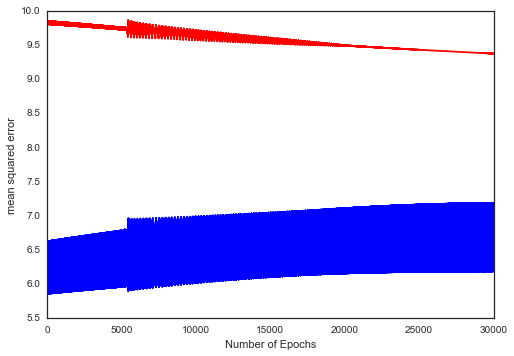

In [289]:
plt.plot(train_monitor, c='r')
plt.plot(val_monitor, c='b')
plt.xlabel('Number of Epochs')
plt.ylabel('mean squared error')
plt.show()

Then, here is the least squares fit, and the comparison with the neural network fit

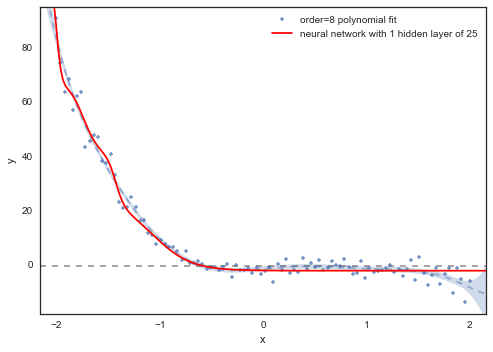

In [290]:
y_hat = theano.function(inputs=[x],
                outputs=y_pred)

x_test = np.array(np.expand_dims(np.linspace(-2.2, 2.2, 200), 1), dtype=theano.config.floatX)
y_test = y_hat(x_test)
order = 8

regr = PolynomialFit1D(np.squeeze(xe), np.squeeze(ye), order= order, 
                       label='order=' + str(order) + ' polynomial fit')
regr.plot(fit_expression=False)
plt.plot(x_test, y_test, label='neural network with 1 hidden layer of ' + str(hidden_size), color='r')
plt.legend(loc='best')